In [1]:
# Drift 제거 
#https://www.kaggle.com/friedchips/clean-removal-of-data-drift

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
df_train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
df_train['open_channels'].value_counts()

0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: open_channels, dtype: int64

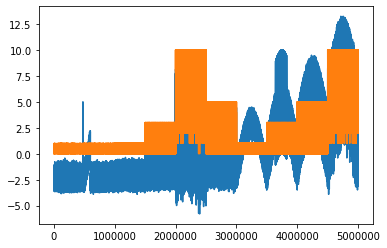

In [5]:
df_train['signal'].plot()
df_train['open_channels'].plot()
plt.show()

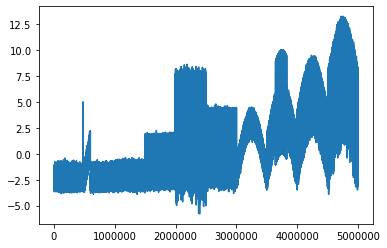

In [6]:
df_train['signal'].plot()
# 3000000 이후로 Input 값의 변화가 발생한다.
# Drift가 되어 있다. 이 Drift를 없애 주자.


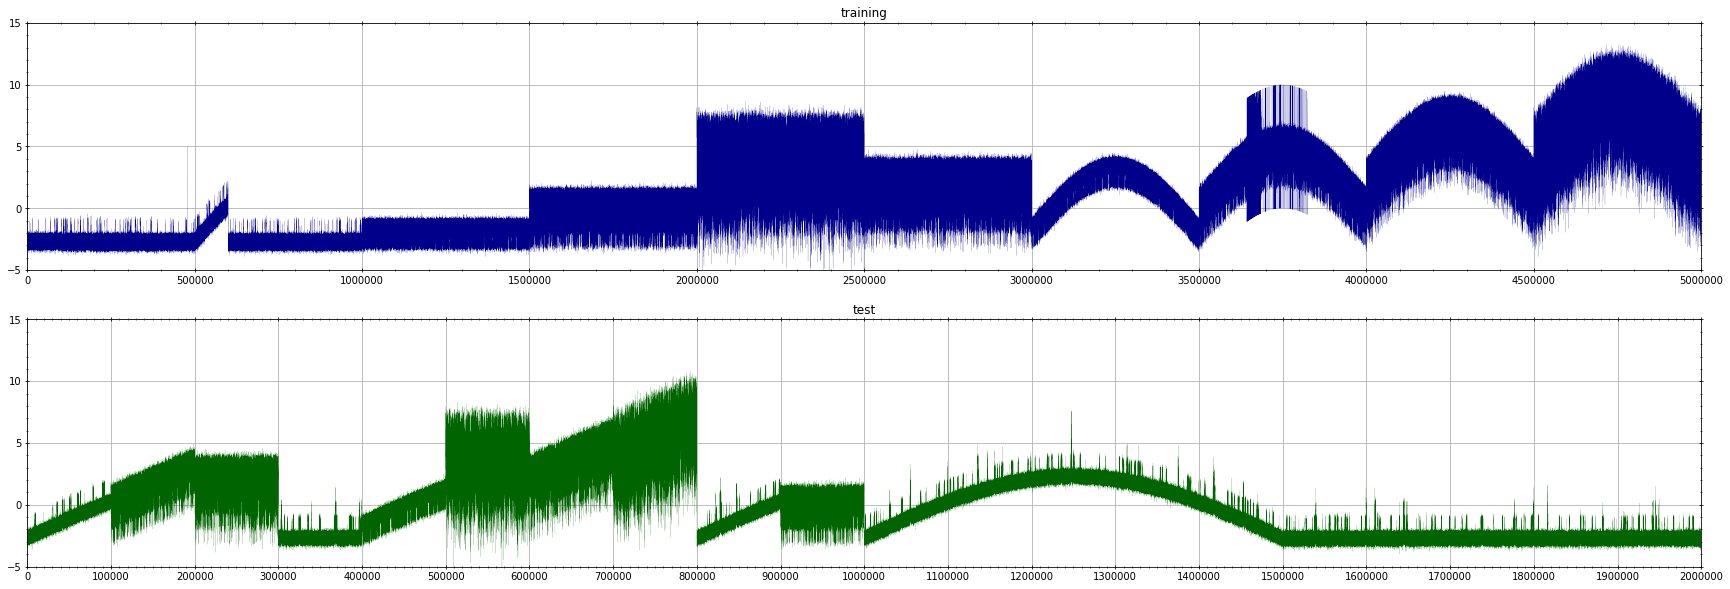

In [7]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)
    
    
fig, axes = create_axes_grid(1,2,30,5)
set_axes(axes[0], x_val=[0,5000000,500000,100000], y_val=[-5,15,5,1])
axes[0].plot(df_train['signal'], color='darkblue', linewidth=.1);
axes[0].set_title('training')
set_axes(axes[1], x_val=[0,2000000,100000,10000], y_val=[-5,15,5,1])
axes[1].set_title('test')
axes[1].plot(df_test['signal'], color='darkgreen', linewidth=.1);

In [8]:
# Shift 된 데이터  - 분리
train_segm_separators = np.concatenate([[0,500000,600000], np.arange(1000000,5000000+1,500000)])
train_segm_signal_groups = [0,0,0,1,2,4,3,1,2,3,4] # from visual identification
train_segm_is_shifted = [False, True, False, False, False, False, False, True, True, True, True] # from visual identification
train_signal = np.split(df_train['signal'].values, train_segm_separators[1:-1])
train_opench = np.split(df_train['open_channels'].values, train_segm_separators[1:-1])

In [9]:
test_segm_separators = np.concatenate([np.arange(0,1000000+1,100000), [1500000,2000000]])
test_segm_signal_groups = [0,2,3,0,1,4,3,4,0,2,0,0] # from visual id
test_segm_is_shifted = [True, True, False, False, True, False, True, True, True, False, True, False] # from visual id
test_signal = np.split(df_test['signal'].values, test_segm_separators[1:-1])

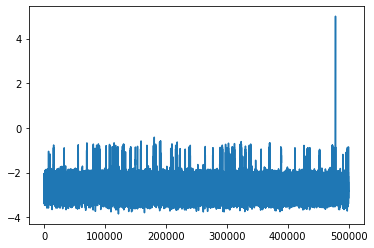

In [10]:
plt.plot(train_signal[0])

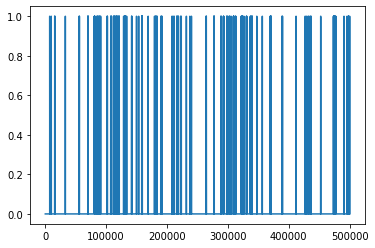

In [11]:
plt.plot(train_opench[0])

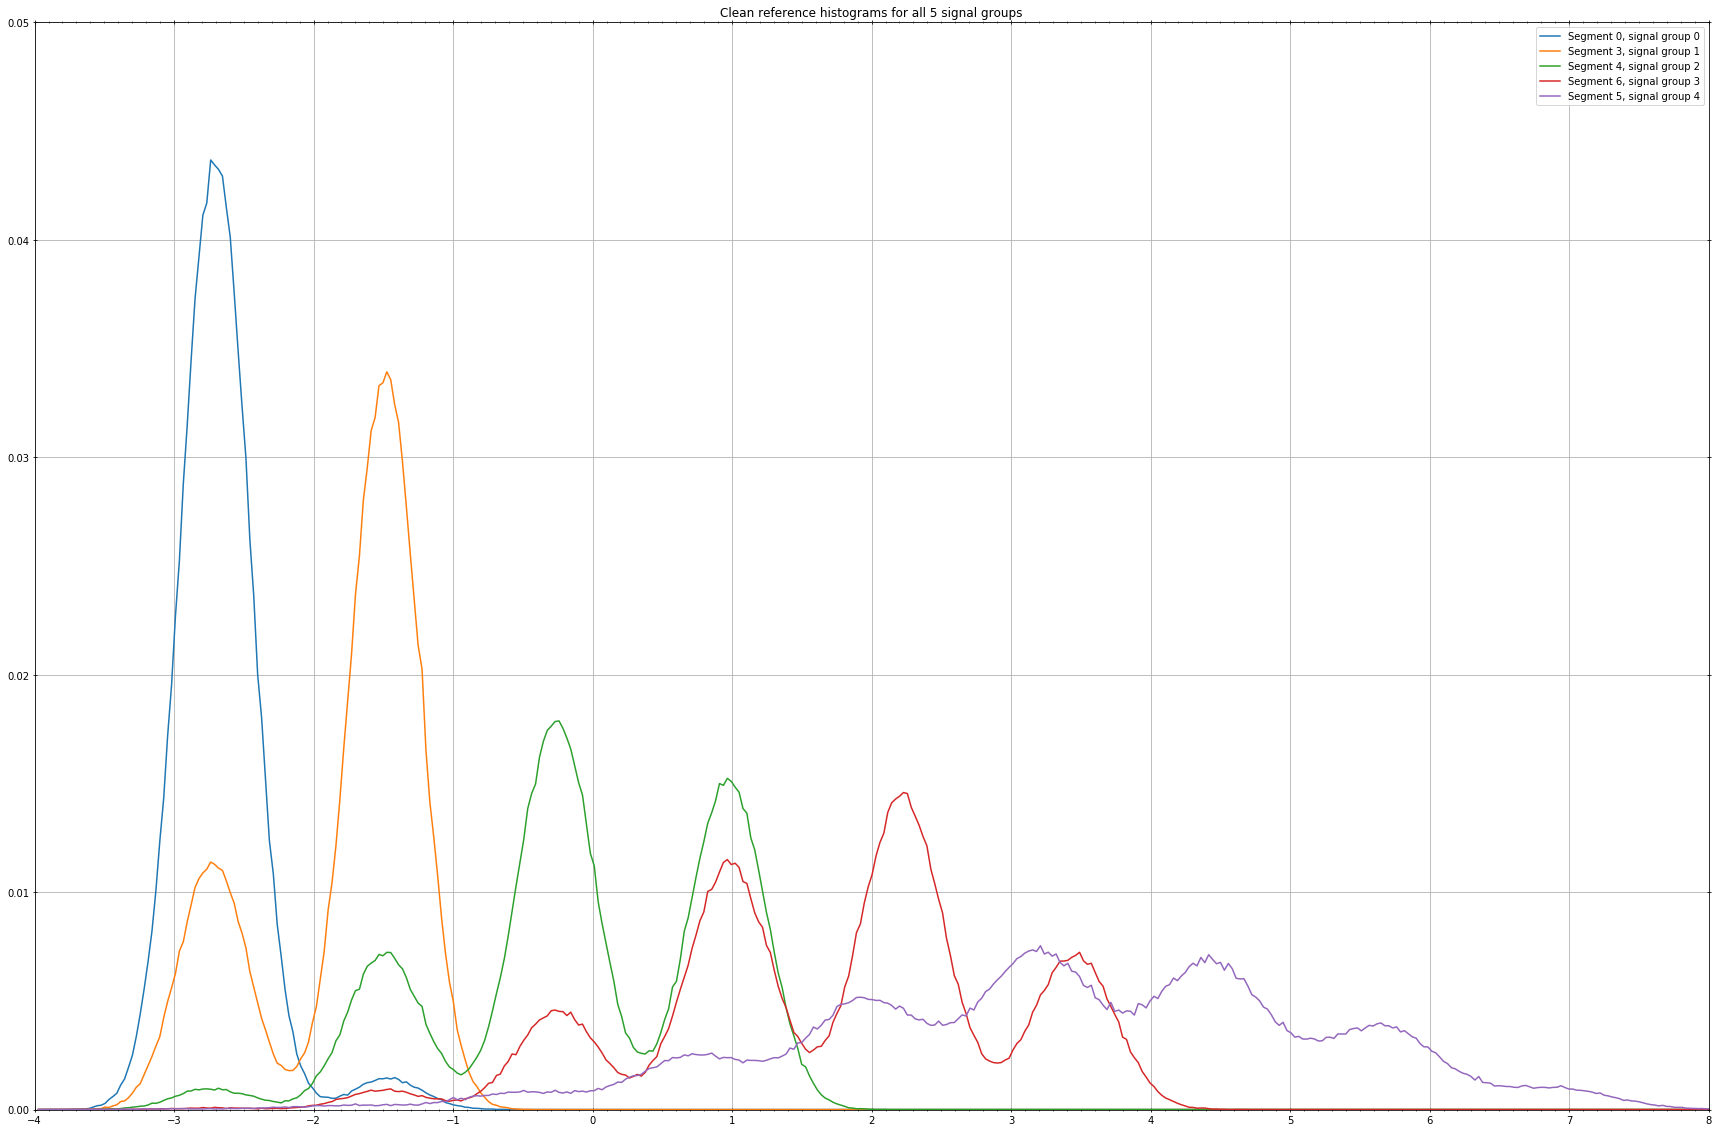

In [12]:
'''
 Drift 없는 Group 데이터를 기반으로 signal histogram을 만든다.
 histogram을 만드는 건 X축을 signal의 Bin 값을 의미하고
 Y축은 그 bin 값에 포함되는 signal의 수로 보면 된다.
 
'''
#create clean signal histograms
fig, axes = create_axes_grid(1,1,30,20)
set_axes(axes, x_val=[-4,8,1,.1], y_val=[0,0.05,0.01,0.01])

clean_hist = []
hist_bins = np.linspace(-4,10,500)

for j,i in enumerate([0,3,4,6,5]):
    clean_hist.append(np.histogram(train_signal[i], bins=hist_bins)[0])
    clean_hist[-1] = clean_hist[-1] / 500000 # normalize histogram
    axes.plot(hist_bins[1:], clean_hist[-1], label='Segment '+str(i)+', signal group '+str(j));
axes.legend();
axes.set_title("Clean reference histograms for all 5 signal groups");

In [13]:
'''
train signal shift 값 찾기
정상적인 histogram과 shift된 histogram의 상관 관계를 통해
shift 된 것을 정상화 시킨다?
- Image 분야에서 histogram shift 방법으로 사용한다.

'''

window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10 # maximum absolute change in shift from window to window+1
train_signal_shift = []

for clean_id in range(len(train_segm_signal_groups)):
    
    group_id = train_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0 # all signal groups start with shift=0
    window_data = train_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)
    # np.roll : 위치를 옮기는 것
    # 
    window_shift = np.array(window_shift)
    train_signal_shift.append(window_shift)   

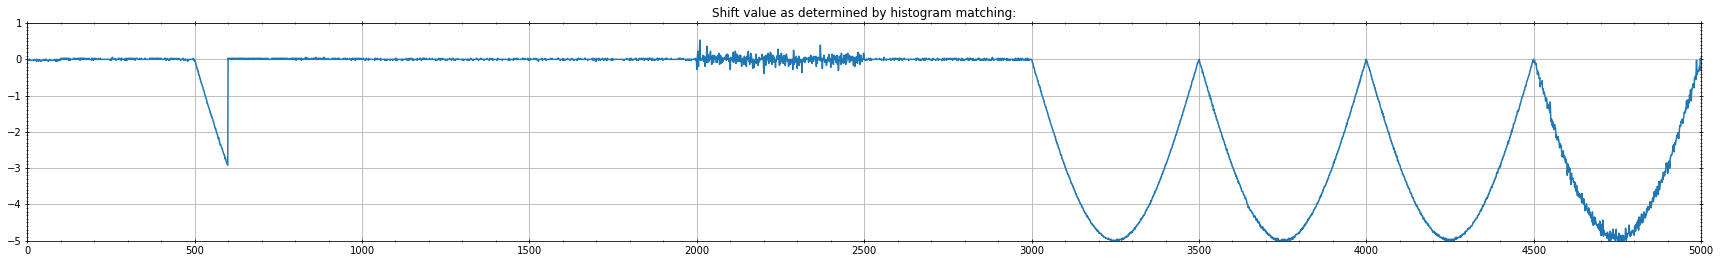

In [14]:
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[0,5000,500,100], y_val=[-5,1,1,.1])
axes.plot(np.concatenate(train_signal_shift));
axes.set_title("Shift value as determined by histogram matching:");

In [15]:
train_signal_shift_clean = []
train_signal_detrend = []

for data, use_fit, signal in zip(train_signal_shift, train_segm_is_shifted, train_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    train_signal_shift_clean.append(data_2)
    train_signal_detrend.append(signal + data_2)

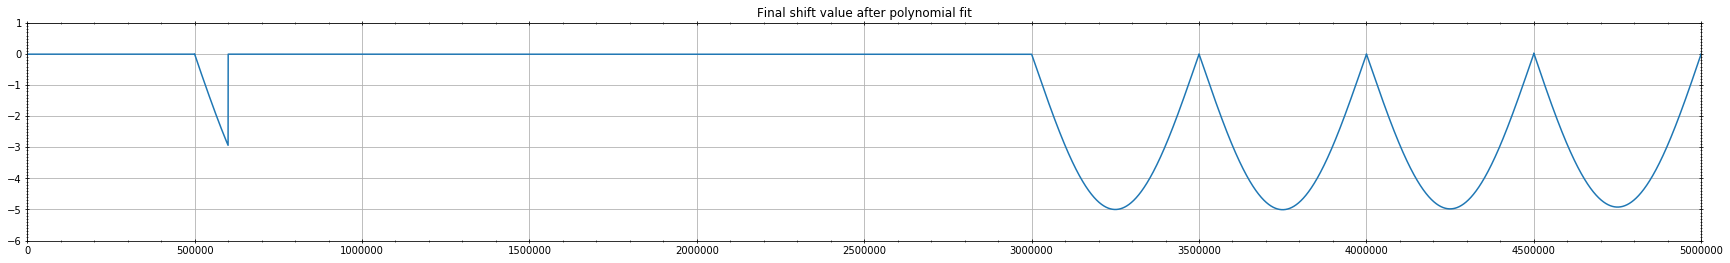

In [16]:
fig, axes = create_axes_grid(1,1,30,4)
set_axes(axes, x_val=[0,5000000,500000,100000], y_val=[-6,1,1,.1])
axes.plot(np.concatenate(train_signal_shift_clean));
axes.set_title("Final shift value after polynomial fit");

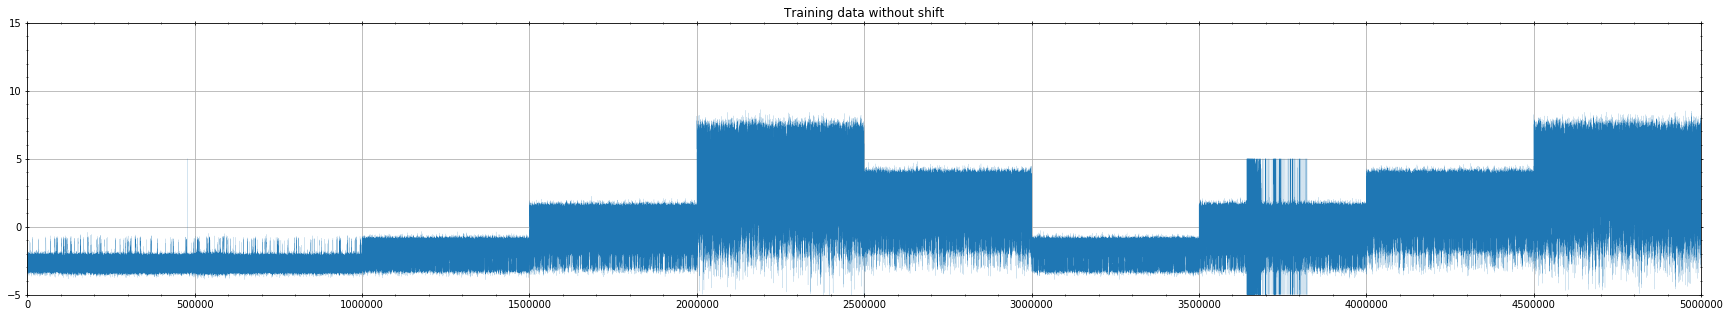

In [17]:
fig, axes = create_axes_grid(1,1,30,5)
set_axes(axes, x_val=[0,5000000,500000,100000], y_val=[-5,15,5,1])
axes.plot(np.concatenate(train_signal_detrend), linewidth=.1);
axes.set_title("Training data without shift");

In [18]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10
test_signal_detrend = []
test_signal_shift = []

for clean_id in range(len(test_segm_signal_groups)):
    
    group_id = test_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0
    window_data = test_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    test_signal_shift.append(window_shift)    

In [19]:
test_signal_shift_clean = []
test_signal_detrend = []
test_remove_shift = [True, True, False, False, True, False, True, True, True, False, True, False]

for data, use_fit, signal in zip(test_signal_shift, test_segm_is_shifted, test_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    test_signal_shift_clean.append(data_2)
    test_signal_detrend.append(signal + data_2)

In [20]:
df_train_detrend = df_train.copy()
df_train_detrend['signal'] = np.concatenate([x for x in train_signal_detrend])
df_train_detrend['open_channels'] = np.concatenate([x for x in train_opench])

df_test_detrend = df_test.copy()
df_test_detrend['signal'] = np.concatenate([x for x in test_signal_detrend])
# df_test_detrend['open_channels'] = np.concatenate([x for x in test_opench])



In [21]:
df_train_detrend.to_csv('train_detrendbyhist.csv',index=False)
df_test_detrend.to_csv('test_detrendbyhist.csv',index=False)

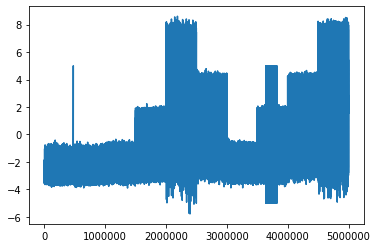

In [22]:
df_train_detrend['signal'].plot()
plt.show()

In [23]:
df_test_detrend#.head()

,time,signal
0,500.0001,-2.675347
1,500.0002,-2.874979
2,500.0003,-2.885611
3,500.0004,-2.460642
4,500.0005,-2.641174
...,...,...
1999995,699.9996,-2.909200
1999996,699.9997,-2.742200
1999997,699.9998,-2.828500
1999998,699.9999,-2.909200
